In [114]:
%cd /content/drive/MyDrive/Digital_Image_Processing_EE608

/content/drive/MyDrive/Digital_Image_Processing_EE608


In [ ]:
!git add .

In [ ]:
!git config --global user.email "Shashankkapoor1994@gmail.com"
!git config --global user.name  "Shashank kapoor"

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Problem 0: Panorama Stitching

#### 1. Take multiple images with some overlap. Perform image stitching and panorama construction. Clearly describe the steps in your implementation. Write down your observations at each step. (10) (Use OpenCV or any Library) [steps: 1.SIFT-feature extraction, 2.Feature Matching,3.RANSAC algorithm, 4.Geometric matrix estimation, 5.Image Registration

##### SIFT-feature extraction

In [2]:
import cv2
def Feature_extraction(path):

  image = cv2.imread(path)
  sift = cv2.xfeatures2d.SIFT_create()
  keypoints, descriptors = sift.detectAndCompute(image, None)
  
  cv2.waitKey(0)
  cv2.destroyAllWindows()

  return  keypoints, descriptors,image

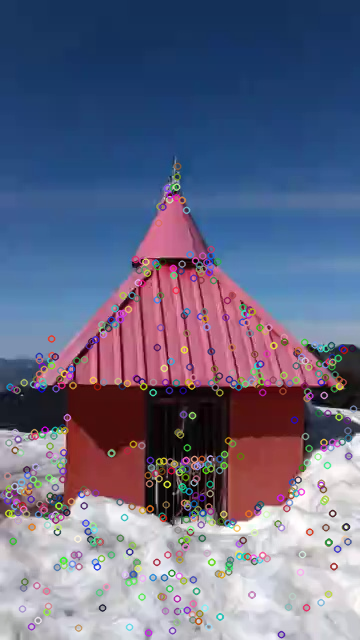

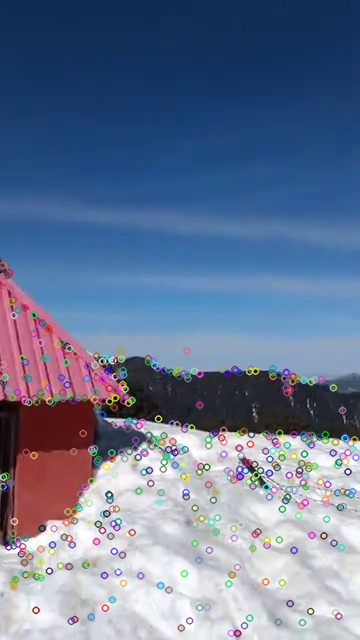

In [3]:
from google.colab.patches import cv2_imshow

key,desc,image =Feature_extraction('/content/drive/MyDrive/Digital_Image_Processing_EE608/s22022_hw4/Data/frame_1.jpg')
image= cv2.drawKeypoints(image, key, None)
cv2_imshow(image)


key,desc,image=Feature_extraction('/content/drive/MyDrive/Digital_Image_Processing_EE608/s22022_hw4/Data/frame_44.jpg')
image= cv2.drawKeypoints(image, key, None)
cv2_imshow(image)

##### Feature Matching

In [4]:
def Feature_matching():
  
  keypoints1, descriptors1, image1 = Feature_extraction('/content/drive/MyDrive/Digital_Image_Processing_EE608/s22022_hw4/Data/frame_1.jpg')
  keypoints2, descriptors2, image2 = Feature_extraction('/content/drive/MyDrive/Digital_Image_Processing_EE608/s22022_hw4/Data/frame_44.jpg')
  
  # Create BFMatcher object
  matcher = cv2.BFMatcher()

  # Match descriptors between images
  matches = matcher.match(descriptors1, descriptors2)

  # Sort matches by distance
  matches = sorted(matches, key=lambda x: x.distance)

  # Draw top 10 matches on input images
  image_with_matches = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:20], None)

  # Display result
  #cv2.imshow('Image with matches', image_with_matches)
  cv2.waitKey(0)
  cv2.destroyAllWindows()
  return  image_with_matches,matches,keypoints1,keypoints2,image1,image2

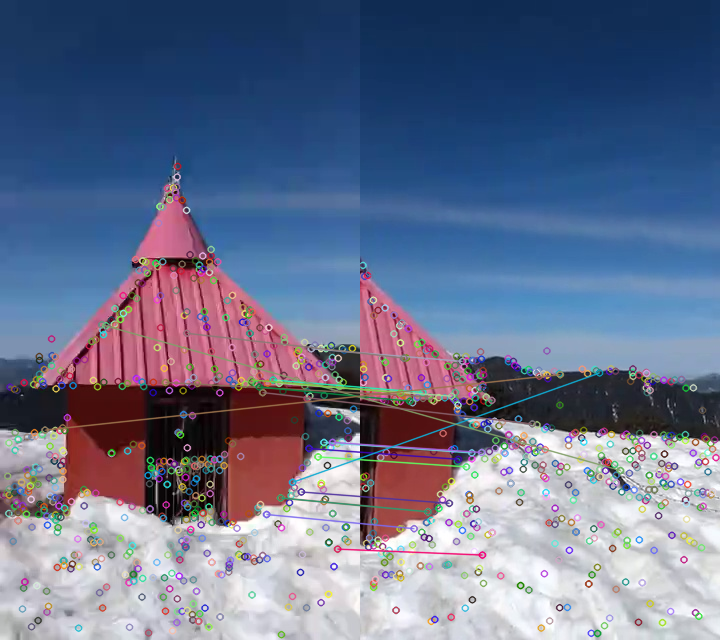

In [5]:
image,_,_,_,_,_=Feature_matching()
cv2_imshow(image)

##### RANSAC algorithm

In [112]:
import cv2
import numpy as np

def ransac():

  _,matches,keypoints1,keypoints2,image1,image2 = Feature_matching()
  
  # Convert keypoints to numpy arrays
  points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
  points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

  # Draw inliers on input images
  ransacReprojThreshold = 20.0
  homography, mask = cv2.findHomography(points1, points2, cv2.RANSAC, ransacReprojThreshold)
  matches_inliers = np.array(matches)[np.where(mask.ravel() == 1)]
  image_with_inliers = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches_inliers, None)

  result_i = cv2.warpPerspective(image2, homography, (image1.shape[1] + image2.shape[1], image1.shape[0]))
  result[0:image1.shape[0], 0:image1.shape[1]] = image1

  blend = cv2.addWeighted(result_i, 0.5, result, 0.5, 0)

  cv2.waitKey(0)
  cv2.destroyAllWindows()
  return image_with_inliers,blend

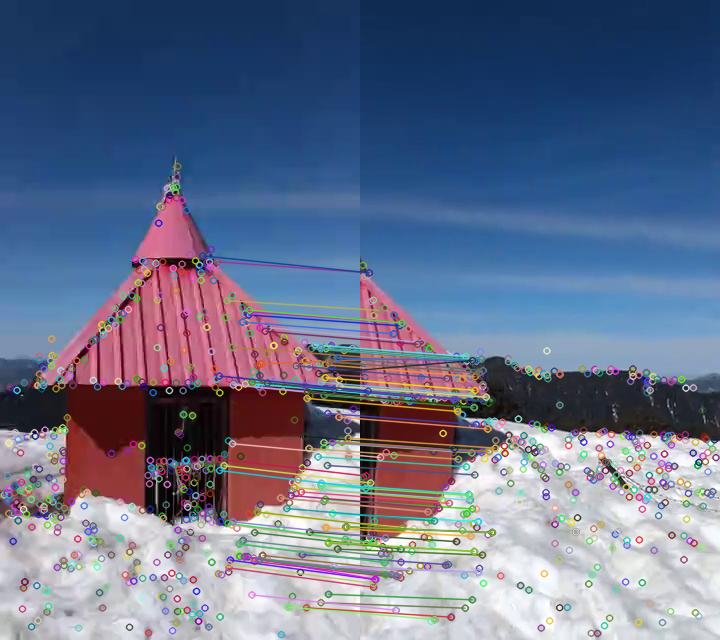

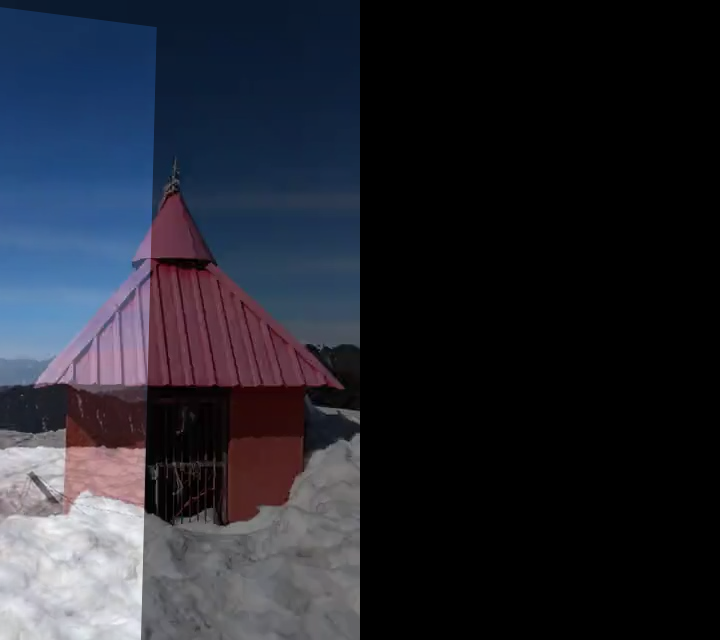

In [113]:
 image,result=ransac()
 cv2_imshow(image)
 cv2_imshow(result)

# Problem 1: Motion Estimation

#### In this problem you will implement the most critical part of the video codec the motion estimator. Do the following:

####1. Use the 3-step search to find motion vectors (check slides for description). (10)
####• Use mean absolute distance (MAD) as your metric.
####• Step 1: Search at 8 location ±4 pixels around current macroblock including (0, 0) (relative to current macroblock).
####• Step 2: search at 8 location ±2 pixels around best match location in Step 1 including best match location.
####• Step 3: search at 8 location ±1 pixels around best match location in Step 2 including best match location.

In [ ]:
import cv2

video_path = 'path/to/video.mp4'
cap = cv2.VideoCapture(video_path)

macroblock_size = 16
search_range = 8

ret, frame = cap.read() # read the first frame
prev_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # convert to grayscale
while True:
    ret, frame = cap.read() # read the next frame
    if not ret:
        break # end of video
    curr_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # convert to grayscale
    motion_vectors = []
    # loop through each macroblock in the current frame
    for row in range(0, curr_frame.shape[0], macroblock_size):
        for col in range(0, curr_frame.shape[1], macroblock_size):
            # extract the current macroblock
            curr_macroblock = curr_frame[row:row+macroblock_size, col:col+macroblock_size]
            # search for the best matching macroblock in the previous frame
            best_mad = float('inf')
            best_row, best_col = row, col
            for i in range(row-search_range, row+search_range+1):
                for j in range(col-search_range, col+search_range+1):
                    # make sure the search location is within the frame
                    if i >= 0 and j >= 0 and i+macroblock_size < prev_frame.shape[0] and j+macroblock_size < prev_frame.shape[1]:
                        # extract the reference macroblock
                        ref_macroblock = prev_frame[i:i+macroblock_size, j:j+macroblock_size]
                        # compute the mean absolute difference between the two macroblocks
                        mad = np.sum(np.abs(curr_macroblock - ref_macroblock))
                        if mad < best_mad:
                            best_mad = mad
                            best_row, best_col = i, j
            # store the motion vector for the current macroblock
            motion_vectors.append((best_row-row, best_col-col))
    # update the previous frame for the next iteration
    prev_frame = curr_frame.copy()

#### 2. Plot the motion vector at each macroblock. You can use the arrow function in matplotlib. (1)

#### 3. Generate the motion compensated predicted frame using the motion vectors and the first frame. (3)

####4. Compute the error between the second frame and its motion compensated predicted version and display it.(1)
####Instructions:
####• Do not use built-in functions.
####• Divide each frame into non-overlapping macroblocks of size 16×16 pixels. Note that the images are of size 176 × 144.
####• Generate motion vectors at each macroblock in the second frame from the first

# Problem 2: Optical Flow

#### 1.[Theory] - Define Optical Flow Equation? Explain Lucas-Kanade algorithm?

In [1]:
'''
1. Optical flow equation:
The optical flow equation relates the motion of pixels between two consecutive frames in an image sequence:

I(x,y,t) = I(x+dx,y+dy,t+dt)

where I(x,y,t) is the intensity of a pixel at position (x,y) and time t, and dx, dy, and dt are the corresponding spatial and 
temporal derivatives of the flow field.

2.Lucas-Kanade algorithm:

The Lucas-Kanade algorithm estimates the optical flow using the following equation:

∑∇I(x,y) [ u v ] = -∑I(x,y,t) ∇I(x,y,t)

where ∇I(x,y) is the gradient of the image at position (x,y), [u v] is the optical flow vector at position (x,y), and ∑ is the 
summation over a local neighborhood around (x,y). The algorithm solves this equation using the least-squares method to obtain the
optical flow vector [u v].

The algorithm also involves a Gaussian smoothing function to reduce the influence of noise and outliers:

∑∇I(x,y) [ u v ] = -∑I(x,y,t) ∇I(x,y,t)

where G(x,y) is a Gaussian smoothing kernel and σ is the standard deviation of the kernel.

The algorithm iteratively refines the optical flow estimates by repeating the above steps on multiple pyramid levels to handle large 
displacements and occlusions.

'''

' Ans.\n\n'

#### 2. [Coding] - Take two videos 1) Slow motion video 2) Fast moving video. Compute optical flow between consecutive frames for the entire video? Visualize optical flow maps and Comment on the magnitude of the optical flow for both the videos? [Use Open-CV/Any Python library]

In [55]:
import cv2
from google.colab.patches import cv2_imshow

# Load video
cap = cv2.VideoCapture('/content/drive/MyDrive/Digital_Image_Processing_EE608/s22022_hw4/Data/slow_video.mp4')

# Parameters for Shi-Tomasi corner detection
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

# Parameters for Lucas-Kanade optical flow
lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Color for optical flow visualization
color = (0, 255, 0)

# Take first frame and detect corners
ret, prev_frame = cap.read()
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
prev_pts = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)

# Create a mask image for drawing purposes
mask = np.zeros_like(prev_frame)

while True:
    # Read new frame
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to grayscale
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate optical flow between previous and current frame
    curr_pts, status, error = cv2.calcOpticalFlowPyrLK(prev_gray, frame_gray, prev_pts, None, **lk_params)

    # Select good points
    good_new = curr_pts[status == 1]
    good_old = prev_pts[status == 1]

    # Draw optical flow vectors
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color, 2)
        frame = cv2.circle(frame, (int(a), int(b)), 5, color, -1)

    # Overlay optical flow on original frame
    img = cv2.add(frame, mask)

    # Show optical flow image
    cv2_imshow(img)

    # Update previous frame and points
    prev_gray = frame_gray.copy()
    prev_pts = good_new.reshape(-1, 1, 2)

    # Exit on ESC key
    if cv2.waitKey(1) == 27:
        break

# Release resources
cap.release()
cv2.destroyAllWindows()



Output hidden; open in https://colab.research.google.com to view.

# Problem 3: Wavelet Transform

#### 1. [Theory] - Explain 2D-Wavelet Transform & 2D-Inverse Wavelet Transform?

In [1]:
'''
The 2D wavelet transform is a signal processing technique used for image compression, feature extraction, and denoising. It involves decomposing a 
two-dimensional image into a series of wavelet coefficients at different scales and orientations. The wavelet coefficients represent the image content
at different levels of detail. The transform can be computed using a bank of filters, typically consisting of a low-pass filter and high-pass filter in 
both horizontal and vertical directions.

The 2D wavelet transform can be performed using the following steps:

1. Decompose the image into its low-pass and high-pass components in both horizontal and vertical directions using a set of filters. This is often referred 
to as a convolution operation.
2. Repeat the above step on the low-pass image to obtain the next level of wavelet coefficients.
3. Continue the above steps until the desired level of decomposition is reached.

The 2D inverse wavelet transform is used to reconstruct the original image from the wavelet coefficients. It involves performing a series of inverse filtering 
operations, starting from the highest level of decomposition, until the original image is obtained. The inverse wavelet transform can be expressed as a linear 
combination of scaling and wavelet functions, with the scaling function providing the low-pass component and the wavelet function providing the high-pass component.

The 2D inverse wavelet transform can be performed using the following steps:

1. Reconstruct the image at the highest level of decomposition using the wavelet coefficients and the corresponding filters.
2. Repeat the above step for each level of decomposition, using the wavelet coefficients and filters at that level.
3. Sum the reconstructed images at each level of decomposition to obtain the final reconstructed image.

Overall, the 2D wavelet transform and 2D inverse wavelet transform are powerful tools for image compression and feature extraction, and have been widely used in
many areas of signal processing and computer vision.
'''

'\nThe 2D wavelet transform is a signal processing technique used for image compression, feature extraction, and denoising. It involves decomposing a \ntwo-dimensional image into a series of wavelet coefficients at different scales and orientations. The wavelet coefficients represent the image content\nat different levels of detail. The transform can be computed using a bank of filters, typically consisting of a low-pass filter and high-pass filter in \nboth horizontal and vertical directions.\n\nThe 2D wavelet transform can be performed using the following steps:\n\n1. Decompose the image into its low-pass and high-pass components in both horizontal and vertical directions using a set of filters. This is often referred \nto as a convolution operation.\n2. Repeat the above step on the low-pass image to obtain the next level of wavelet coefficients.\n3. Continue the above steps until the desired level of decomposition is reached.\n\nThe 2D inverse wavelet transform is used to reconstruc

#### 2. Implement Wavelet Transform using the library (OpenCV/Pywavelet)? Implement image denoising algorithm using the Wavelet Transform? (https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html)

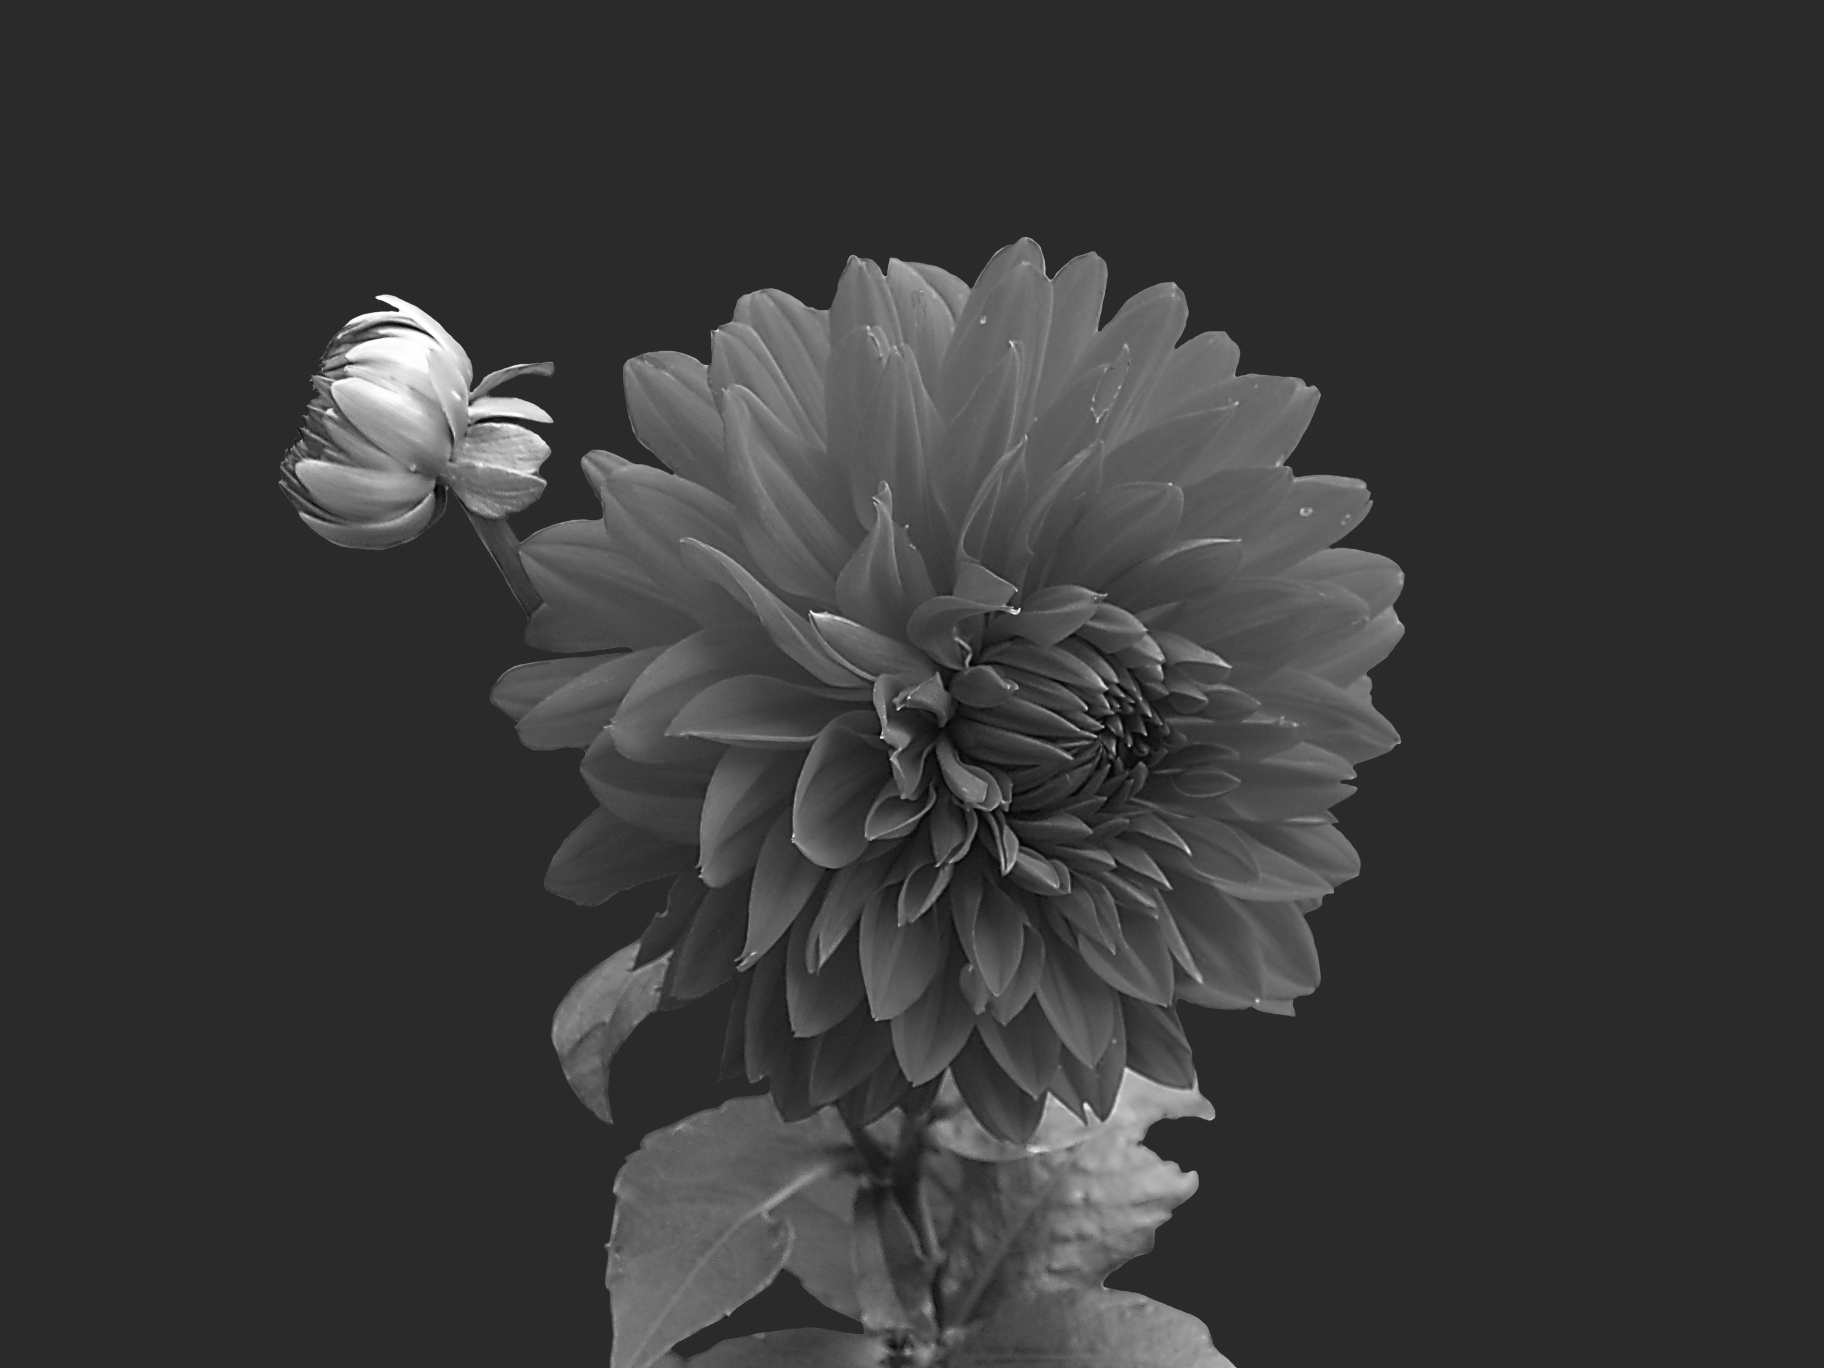

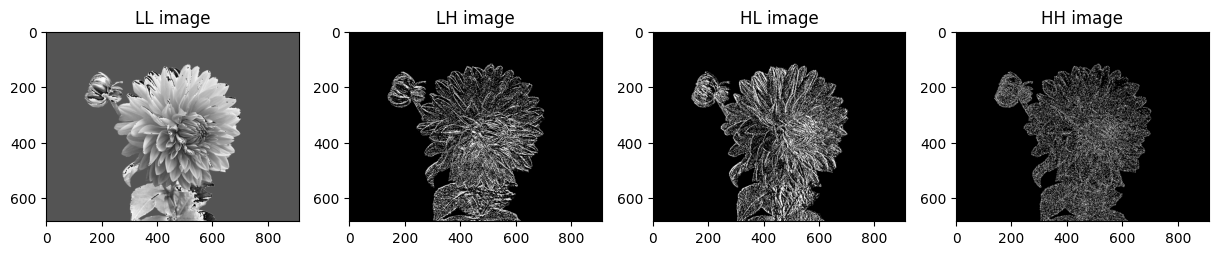

In [24]:
import pywt
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

img = cv2.imread('/content/drive/MyDrive/Digital_Image_Processing_EE608/s22022_hw4/Data/Flower.jpg',0)
img = cv2.resize(img,None, fx=0.5, fy=0.5)
coeffs = pywt.dwt2(img, 'haar')
LL, (LH, HL, HH) = coeffs

cv2_imshow(img)

fig, ax = plt.subplots(1, 4, figsize=(15, 10),sharex=True, )
ax[0].set_title("LL image")
ax[0].imshow(LL.astype(np.uint8), cmap='gray')
ax[1].set_title("LH image")
ax[1].imshow(LH.astype(np.uint8), cmap='gray')
ax[2].set_title("HL image")
ax[2].imshow(HL.astype(np.uint8), cmap='gray')
ax[3].set_title("HH image")
ax[3].imshow(HH.astype(np.uint8), cmap='gray')

cv2.waitKey(0)
cv2.destroyAllWindows()
